In [1]:
#imports
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
from moviepy.editor import VideoFileClip
%matplotlib inline

done calibrating camera


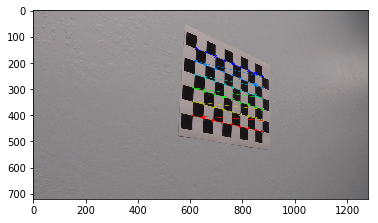

In [2]:
#read images
cal_image_file_names = glob.glob('camera_cal/calibration*.jpg')
num_of_files = len(cal_image_file_names)

#chessboard rows and columns
nx = 9
ny = 6

#lists of points needed for camera calibration
object_points = []
image_points = []

initial_objp = np.zeros((nx*ny,3), np.float32)
initial_objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

for idx, image_file_name in enumerate(cal_image_file_names):
    cal_image = cv2.imread(image_file_name)
    gray_cal_image = cv2.cvtColor(cal_image, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray_cal_image, (nx, ny), None)
    if ret == True:
        image_points.append(corners)
        object_points.append(initial_objp)
        cal_image = cv2.drawChessboardCorners(cal_image, (nx, ny), corners, ret)
        plt.imshow(cal_image)
        
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(object_points, image_points, (720,1280), None, None)   
print('done calibrating camera')

In [3]:
#helper variables and methods
def get_random_image_from_path(path, num_of_files_in_path):
    rand_int = np.random.randint(1, num_of_files_in_path)
    random_test_image = cv2.imread('{}{}.jpg'.format(path,rand_int))
    return random_test_image

def display_two_images(img1, img2):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(img1, cmap='gray')
    ax1.set_title('First Image', fontsize=30)
    ax2.imshow(img2, cmap='gray')
    ax2.set_title('Second Image', fontsize=30)
    
def display_three_images(img1, img2, img3):
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
    ax1.imshow(img1)
    ax1.set_title('First Image', fontsize=30)
    ax2.imshow(img2)
    ax2.set_title('Second Image', fontsize=30)
    ax3.imshow(img3)
    ax3.set_title('Third Image', fontsize=30)
    
def get_histogram(img, plot=False):
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    if plot:
        plt.plot(histogram)
    return histogram
    
def draw_lines(img, points, plot=False):
    copy = img.copy()
    cv2.line(copy, tuple(points[0]), tuple(points[1]), color=[255, 0, 0], thickness=3)
    cv2.line(copy, tuple(points[2]), tuple(points[3]), color=[255, 0, 0], thickness=3)
    if plot:
        plt.imshow(copy)
    return copy
    
def draw_poly_lines(img, points, plot=False):
    reshaped_points = points.reshape((-1,1,2))
    copy = img.copy()
    cv2.polylines(copy,[reshaped_points],True,(255,0,0), thickness=3)
    if plot:
        plt.imshow(copy)
    return copy

def get_histogram(img, plot=False):
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    if plot:
        plt.plot(histogram)
    return histogram
    
def guassian_blur(img, kernel):
    return cv2.GaussianBlur(img, (kernel, kernel), 0)

def region_of_interest(img):
    height, width = img.shape[:2]
    mask = np.zeros_like(img)
    roi_vertices = np.array([[0,height-1], [width/2, int(0.5*height)], [width-1, height-1]], dtype=np.int32)
    cv2.fillPoly(mask, [roi_vertices], 1)
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def calibrate_and_undistort(img, objpoints, imgpoints):
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary_output

def mag_threshold(img, sobel_kernel=3, thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= thresh[0]) & (gradmag <= thresh[1])] = 1
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return binary_output

def combine_gradient_thredholds(img, sobel_x_thresh, dir_thresh, sobel_y_thresh=None, mag_thresh=None, ksize=5):
    gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=sobel_x_thresh)
    if sobel_y_thresh:
        grady = abs_sobel_thresh(img, orient='y', sobel_kernel=ksize, thresh=sobel_y_thresh)
        xy_grad_cond = (gradx == 1) & (grady == 1)
    else:
        xy_grad_cond = (gradx == 1)
    dir_binary = dir_threshold(img, sobel_kernel=ksize, thresh=dir_thresh)
    if mag_thresh:
        mag_binary = mag_threshold(img, sobel_kernel=ksize, thresh=mag_thresh)
        dir_mag_cond = ((mag_binary == 1) & (dir_binary == 1))
    else:
        dir_mag_cond = (dir_binary == 1)
    grad = np.zeros_like(dir_binary)
    grad[( xy_grad_cond ) | (dir_mag_cond)] = 1
    return grad
    
def get_thresholded_image(img, sobel_thresh, dir_thresh=(-(np.pi/2),np.pi/2), color_thresh=150, s_thresh=(0,255), l_thresh=(0,255), ksize=3 ):
    sx_binary = abs_sobel_thresh(img, 'x', ksize, sobel_thresh)
    dir_binary = dir_threshold(img, ksize, dir_thresh)
    combined_condition = ((sx_binary == 1) & (dir_binary == 1))
    
    R = img[:,:,2]
    G = img[:,:,1]
    combined = np.zeros_like(R)
    rg_condition = (R > color_thresh) & (G > color_thresh)
    
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    S = hls[:,:,2]
    L = hls[:,:,1]
    s_thresh = (100, 255)
    s_condition = (S > s_thresh[0]) & (S <= s_thresh[1])
    l_thresh = (120, 255)
    l_condition = (L > l_thresh[0]) & (L <= l_thresh[1])

    # combine all the thresholds
    combined[(rg_condition & l_condition) & (s_condition | combined_condition)] = 1
    return combined

def perspective_transform(img, src, dst, inv=False):
    if inv:
        M = cv2.getPerspectiveTransform(dst, src)    
    else:
        M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)
    return warped


def image_of_interest(img, sobel_thresh, dir_thresh, color_thresh, s_thresh, l_thresh, persp_trans_src, persp_trans_dst, ksize):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    thresholded_undist = get_thresholded_image(undist, sobel_thresh, dir_thresh, color_thresh, s_thresh, l_thresh, ksize )
    processed_image = region_of_interest(thresholded_undist)
    warped = perspective_transform(processed_image, persp_trans_src, persp_trans_dst)
    return warped

def curvature_radius(x_vals, rows, x_meter_per_pix, y_meter_per_pix):
    y_points = np.linspace(0, rows-1, rows)
    y_vals = np.max(y_points)
    curve = np.polyfit(y_points * y_meter_per_pix, x_vals * x_meter_per_pix, 2)
    conversion_term = (2*curve[0] * y_vals * y_meter_per_pix + curve[1])
    numerator_base = (1 + conversion_term**2)
    radius = (numerator_base**1.5) / np.absolute(2*curve[0])
    return radius

#generates a predictions for the lane line
def get_line_predictions(non_zeros_x, non_zeros_y, left_coordinates, right_coordinates, num_rows):
    left_x = non_zeros_x[left_coordinates]
    left_y = non_zeros_y[left_coordinates]
    
    if(left_y.size == 0 or left_x.size == 0):
        return None, None

    # Fit the polynomial
    polyfit_left = np.polyfit(left_y, left_x, 2)

    right_x = non_zeros_x[right_coordinates]
    right_y = non_zeros_y[right_coordinates]
    
    if(right_y.size == 0 or right_x.size == 0):
        return None, None

    # Fit the polynomial & generate predictions
    polyfit_right = np.polyfit(right_y, right_x, 2)
    y_points = np.linspace(0, num_rows-1, num_rows)
    left_x_predictions = polyfit_left[0] * y_points**2 + polyfit_left[1] * y_points + polyfit_left[2]
    right_x_predictions = polyfit_right[0] * y_points**2 + polyfit_right[1] * y_points + polyfit_right[2]
    return left_x_predictions, right_x_predictions


def full_sliding_window_search(warped, non_zeros_x, non_zeros_y, num_rows, num_windows=10, window_half_width=50, min_pixels=100):
    window_height = np.int(num_rows/num_windows)
    histogram = np.sum(warped[warped.shape[0]//2:,:], axis=0)
    half_width = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:half_width])
    rightx_base = np.argmax(histogram[half_width:]) + half_width

    left_coordinates = []
    right_coordinates = []

    for window in range(num_windows):
        y_max = num_rows - window*window_height
        y_min = num_rows - (window+1)* window_height
        left_x_min = leftx_base - window_half_width
        left_x_max = leftx_base + window_half_width
        good_left_window_coordinates = ((non_zeros_x >= left_x_min) & (non_zeros_x <= left_x_max) & (non_zeros_y >= y_min) & (non_zeros_y <= y_max)).nonzero()[0]
        left_coordinates.append(good_left_window_coordinates)
        if len(good_left_window_coordinates) > min_pixels:
            leftx_base = np.int(np.mean(non_zeros_x[good_left_window_coordinates]))
        right_x_min = rightx_base - window_half_width
        right_x_max = rightx_base + window_half_width
        good_right_window_coordinates = ((non_zeros_x >= right_x_min) & (non_zeros_x <= right_x_max) & (non_zeros_y >= y_min) & (non_zeros_y <= y_max)).nonzero()[0]
        right_coordinates.append(good_right_window_coordinates)
        if len(good_right_window_coordinates) > min_pixels:
            rightx_base = np.int(np.mean(non_zeros_x[good_right_window_coordinates]))

    left_coordinates = np.concatenate(left_coordinates)
    right_coordinates = np.concatenate(right_coordinates)
    left_x_predictions, right_x_predictions = get_line_predictions(non_zeros_x, non_zeros_y, left_coordinates, right_coordinates, num_rows)
    return left_x_predictions, right_x_predictions

def margin_search(warped, polyfit_left, non_zeros_x, non_zeros_y, margin=100):
    left_x_predictions = polyfit_left[0] * non_zeros_y**2 + polyfit_left[1] * non_zeros_y + polyfit_left[2]
    left_coordinates = ((non_zeros_x >= left_x_predictions - margin) & (non_zeros_x <= left_x_predictions + margin)).nonzero()[0]

    right_x_predictions = polyfit_right[0] * non_zeros_y**2 + polyfit_right[1] * non_zeros_y + polyfit_right[2]
    right_coordinates = ((non_zeros_x >= right_x_predictions - margin) & (non_zeros_x <= right_x_predictions + margin)).nonzero()[0]

    left_x_predictions, right_x_predictions = get_line_predictions(non_zeros_x, non_zeros_y, left_coordinates, right_coordinates, num_rows)
    return left_x_predictions, right_x_predictions

def get_averaged_line(previous_lines, new_line, num_frames=10):
    if new_line is None:
        if len(previous_lines) == 0:
            return previous_lines, None
        else:
            return previous_lines, previous_lines[-1]
    else:
        if len(previous_lines) < num_frames:
            previous_lines.append(new_line)
            return previous_lines, new_line
        else:
            previous_lines[0:num_frames-1] = previous_lines[1:]
            previous_lines[num_frames-1] = new_line
            new_line = np.zeros_like(new_line)
            for i in range(num_frames):
                new_line += previous_lines[i]
            new_line /= num_frames
            return previous_lines, new_line      

In [5]:
def pipeline(img):
    #variables
    polyfit_right = None
    polyfit_left = None
    past_good_right_lines = []
    past_good_left_lines = []
    average_gap = 0
    img_shape = img.shape
    img_size = (img_shape[1], img_shape[0])
    ksize=3
    sobel_thresh=(10,200)
    dir_thresh=(.5, 1.5)
    color_thresh = 150
    s_thresh=(100,255)
    l_thresh=(120,255)
    persp_trans_src = np.float32([[220,720],[1110, 720],[722, 470],[570, 470]])
    persp_trans_dst = np.float32([[320,720],[920, 720],[920, 1],[320, 1]])
    y_meter_per_pix = 30/720
    x_meter_per_pix = 3.7/700
    
    # get undistorted, thresholded, region-masked, perspecitve-transformed image
    warped = image_of_interest(img, sobel_thresh, dir_thresh, s_thresh, l_thresh, persp_trans_src, persp_trans_dst, ksize)
    output = np.dstack((warped, warped, warped))*255
    
    #get non-zero pixels
    non_zeros = warped.nonzero()
    non_zeros_y = non_zeros[0]
    non_zeros_x = non_zeros[1]
    num_rows = warped.shape[0]
    y_points = np.linspace(0, num_rows-1, num_rows)
    
    if (polyfit_left is None) or (polyfit_right is None): #first hit, hence full search
        full_search = True
        left_x_predictions, right_x_predictions = full_sliding_window_search(warped, non_zeros_x, non_zeros_y, num_rows)
    else:
        full_search = False # Else margin search
        left_x_predictions, right_x_predictions = margin_search(warped, polyfit_left, non_zeros_x, non_zeros_y, margin=100)
    
    if (left_x_predictions is None or right_x_predictions is None):
        if not full_search:
            left_x_predictions, right_x_predictions = full_sliding_window_search(warped, non_zeros_x, non_zeros_y, num_rows)
            
    no_use_lines = False
            
    if (left_x_predictions is None or right_x_predictions is None):
        no_use_lines = True
    else:
        avg_difference = np.mean(right_x_predictions - left_x_predictions)
        if average_gap == 0:
            average_gap = avg_difference
        if (avg_difference < (0.7 * average_gap) or avg_difference > (1.3 * average_gap)):
            no_use_lines = True
            if not full_search:
                left_x_predictions, right_x_predictions = full_sliding_window_search(warped, non_zeros_x, non_zeros_y, num_rows)
                if (left_x_predictions is None or right_x_predictions is None):
                    no_use_lines = True
                else:
                    avg_difference = np.mean(right_x_predictions - left_x_predictions)
                    if (avg_difference < (0.7 * average_gap) or avg_difference > (1.3 * average_gap)):
                        no_use_lines = True
                    else:
                        no_use_lines = False
        else:
            no_use_lines = False
            
    if no_use_lines:
        polyfit_left = None
        polyfit_right = None
        if len(past_good_left_lines) == 0 and len(past_good_right_lines) == 0:
            return img
        else:
            left_x_predictions = past_good_left_lines[-1]
            right_x_predictions = past_good_right_lines[-1]
    else:
        past_good_left_lines, left_x_predictions = get_averaged_line(past_good_left_lines, left_x_predictions)
        past_good_right_lines, right_x_predictions = get_averaged_line(past_good_right_lines, right_x_predictions)
        avg_difference = np.mean(right_x_predictions - left_x_predictions)
        average_gap = (0.9 * average_gap) + (0.1 * avg_difference)
    
    left_line_window = np.array(np.transpose(np.vstack([left_x_predictions, y_points])))
    right_line_window = np.array(np.flipud(np.transpose(np.vstack([right_x_predictions, y_points]))))
    
    
    ####compute
    left_rad = curvature_radius(left_x_predictions, num_rows, x_meter_per_pix, y_meter_per_pix)
    right_rad = curvature_radius(right_x_predictions, num_rows, x_meter_per_pix, y_meter_per_pix)
    average_rad = (left_rad + right_rad)/2

    # compute the offset from the center
    lane_center = (right_x_predictions[719] + left_x_predictions[719])/2
    offset_in_pixels = abs(img_shape[1]/2 - lane_center)
    offset_in_mtrs = offset_in_pixels * x_meter_per_pix

    curve_measure_string = "Radius of curvature: {}".format(average_rad)
    offset_measure_string = "Center offset: {}".format(offset_in_mtrs)
    
    poly_vertices = np.vstack([left_line_window, right_line_window])
    cv2.fillPoly(output, np.int_([poly_vertices]), [0,255, 0])
    unwarped = perspective_transform(output, persp_trans_src, persp_trans_dst, inv=True)
    result = cv2.addWeighted(img, 1, unwarped, 0.3, 0)
    
    cv2.putText(result, curve_measure_string , (100, 70), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=2)
    cv2.putText(result, offset_measure_string, (100, 130), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=2)
    
    return result

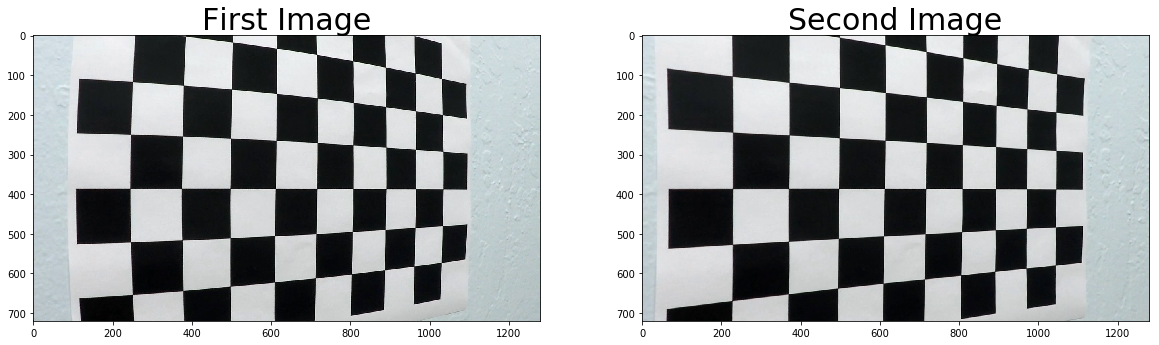

In [41]:
#test random calib image
test_img = get_random_image_from_path('camera_cal/calibration', 20)
undist_img = calibrate_and_undistort(test_img, object_points, image_points)
display_two_images(test_img, undist_img)

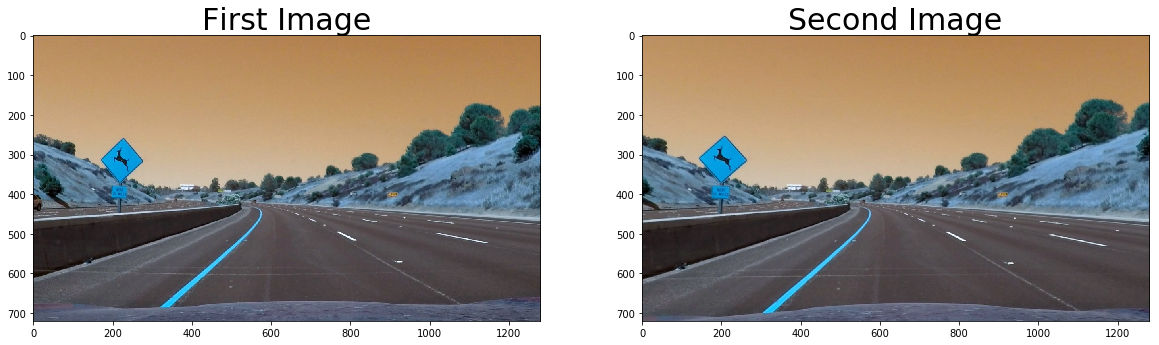

In [10]:
#test random test image
test_img = get_random_image_from_path('test_images/test', 6)
undist_img = calibrate_and_undistort(test_img, object_points, image_points)
display_two_images(test_img, undist_img)

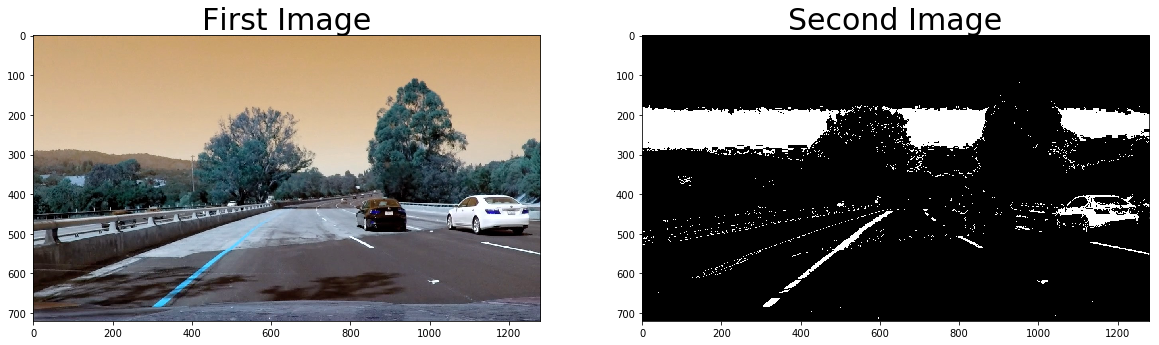

In [15]:
#test thresholds on random test image
test_img = get_random_image_from_path('test_images/test', 6)
thresh_img = get_thresholded_image(test_img, (10,200), (.5, 1.5), 150, (100,255), (120,255), 3)
display_two_images(test_img, thresh_img)

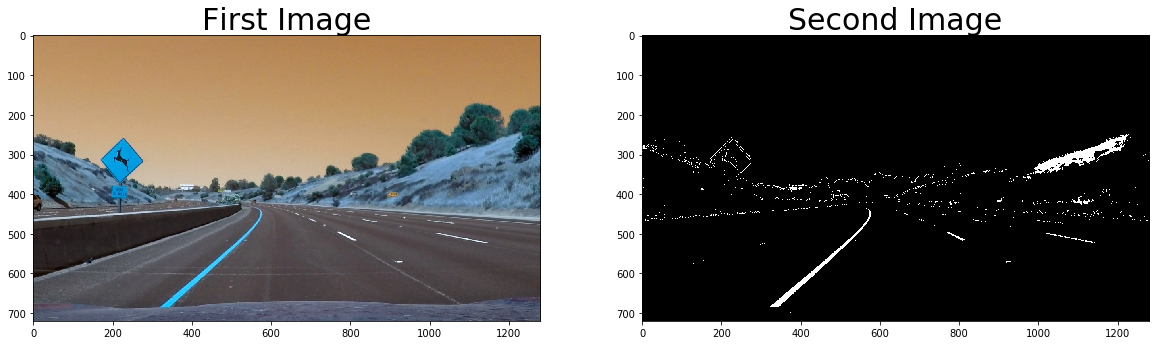

In [33]:
#test thresholds on random test image
test_img = get_random_image_from_path('test_images/test', 6)
thresh_img = get_thresholded_image(test_img, (10,200), (.5, 1.5), 150, (100,255), (120,255), 3)
display_two_images(test_img, thresh_img)

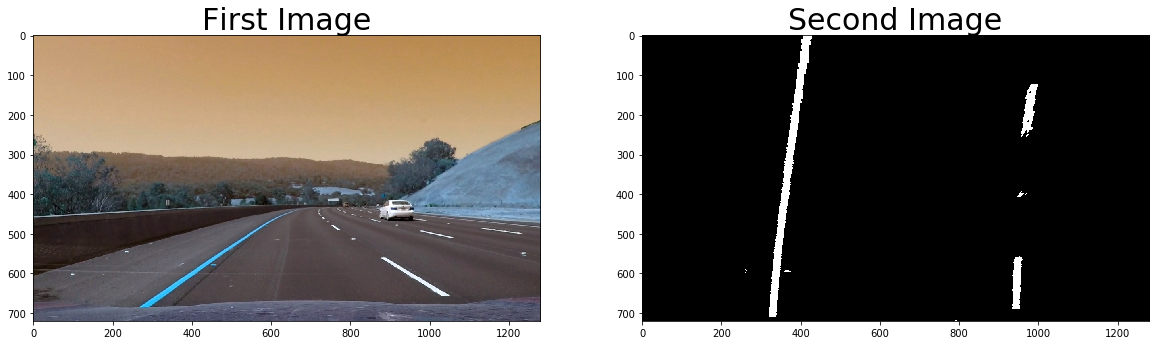

In [25]:
#test undist/threshold/mask/birds-eye on random test image along with histogram
test_img = get_random_image_from_path('test_images/test', 6)
warped = image_of_interest(test_img, (10,200), (.5, 1.5), (100,255), (120,255), np.float32([[220,720],[1110, 720],[722, 470],[570, 470]]), np.float32([[320,720],[920, 720],[920, 1],[320, 1]]), ksize=3)
display_two_images(test_img, warped)
image_shape = test_img.shape

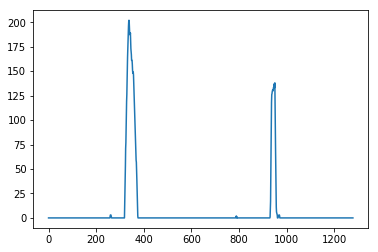

In [27]:
histogram = get_histogram(warped, plot=True)

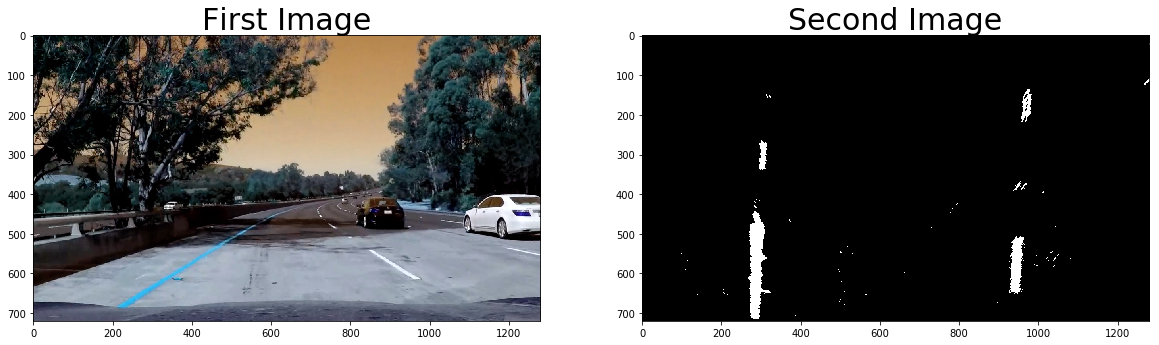

In [28]:
#test undist/threshold/mask/birds-eye on random test image along with histogram
test_img = get_random_image_from_path('test_images/test', 6)
warped = image_of_interest(test_img, (10,200), (.5, 1.5), (100,255), (120,255), np.float32([[220,720],[1110, 720],[722, 470],[570, 470]]), np.float32([[320,720],[920, 720],[920, 1],[320, 1]]), ksize=3)
display_two_images(test_img, warped)
image_shape = test_img.shape

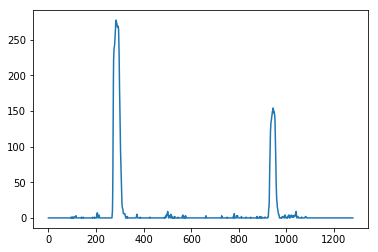

In [29]:
histogram = get_histogram(warped, plot=True)

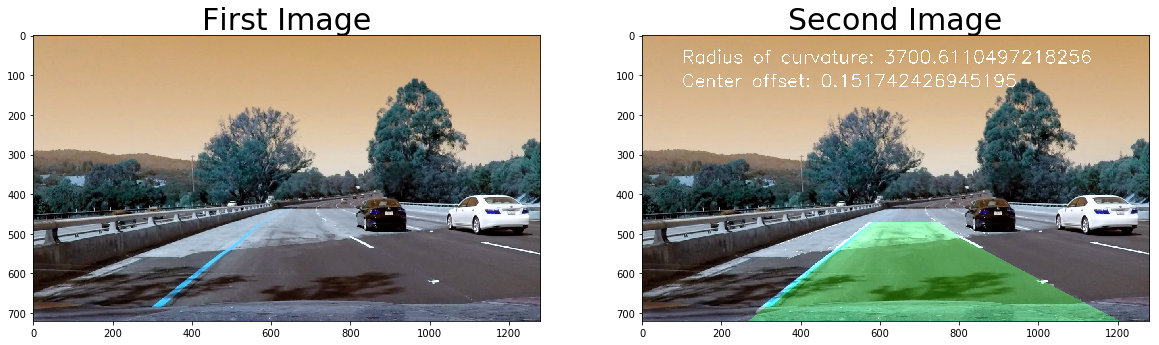

In [7]:
#test pipeline output on random test image
test_img = get_random_image_from_path('test_images/test', 6) 
final = pipeline(test_img)
display_two_images(test_img, final)

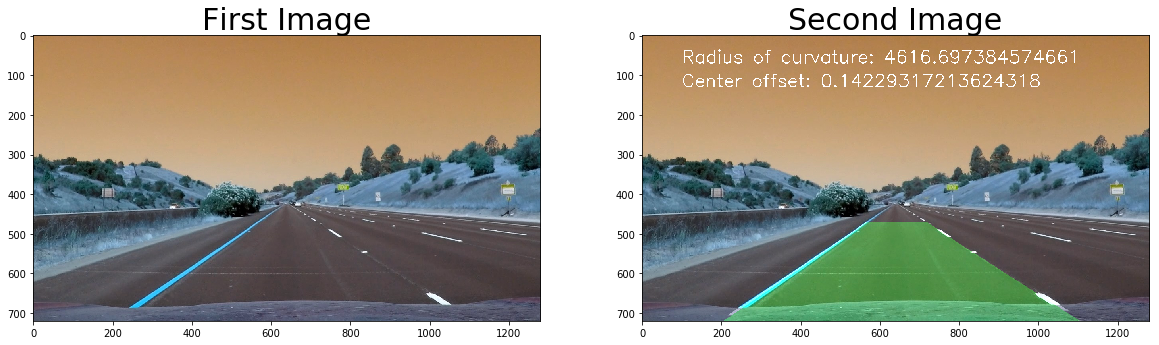

In [32]:
#test pipeline output on random test image
test_img = get_random_image_from_path('test_images/straight_lines', 2) 
final = pipeline(test_img)
display_two_images(test_img, final)

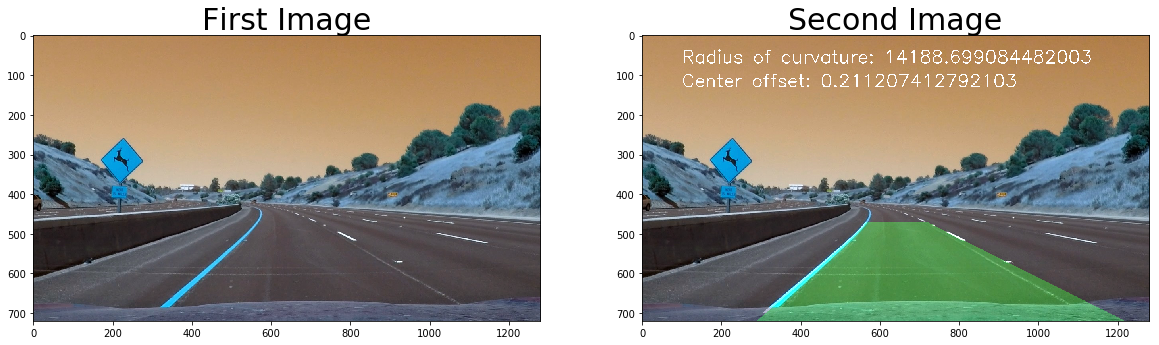

In [34]:
#test pipeline output on random test image
test_img = get_random_image_from_path('test_images/test', 6) 
final = pipeline(test_img)
display_two_images(test_img, final)

In [6]:
#create video
output = 'lane_lines.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(pipeline)
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video lane_lines.mp4
[MoviePy] Writing video lane_lines.mp4


100%|█████████▉| 1260/1261 [03:33<00:00,  6.09it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: lane_lines.mp4 

CPU times: user 3min 15s, sys: 37.9 s, total: 3min 53s
Wall time: 3min 35s
